In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (40.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120893 files and direc

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import datetime
from concurrent.futures import ThreadPoolExecutor
from itertools import repeat
from tqdm.auto import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, RNN, Dropout, Flatten
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumBarunGothic')

In [ ]:
# seed 고정
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)

tf.random.set_seed(SEED)
np.random.seed(SEED)

# load

In [ ]:
# 심리지수 없는.ver
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/한이음/시계열_최종(심리지수제외).xlsx')
df = df.drop(df.columns[0], axis=1)
df.head()

,시점,매매가격지수,금리,국내총생산,대출금리,아파트거래량
0,2019-01-01,75.859101,1.75,"455,551.1",3.12,91868
1,2019-02-01,75.772352,1.75,"455,551.1",3.08,78825
2,2019-03-01,75.626463,1.75,"455,551.1",3.04,90720
3,2019-04-01,75.443869,1.75,"480,832.1",2.98,89977
4,2019-05-01,75.339340,1.75,"480,832.1",2.93,82498


In [ ]:
df.to_excel("/content/drive/MyDrive/Colab Notebooks/한이음/시계열_base_최종.xlsx", sheet_name='Sheet1')

In [ ]:
# 심리지수 포함.ver
df1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/한이음/시계열_base_최종.xlsx')
df1 = df1.drop(df1.columns[0], axis=1)
df1.head()

,시점,심리지수,매매가격지수,국내총생산,금리,대출금리,아파트거래량
0,2019-01-01,122,75.859101,"455,551.1",1.75,3.12,91868
1,2019-02-01,114,75.772352,"455,551.1",1.75,3.08,78825
2,2019-03-01,171,75.626463,"455,551.1",1.75,3.04,90720
3,2019-04-01,174,75.443869,"480,832.1",1.75,2.98,89977
4,2019-05-01,183,75.339340,"480,832.1",1.75,2.93,82498


In [ ]:
correlation = df.corr()
correlation

,매매가격지수,금리,대출금리,아파트거래량
매매가격지수,1.000000,0.241281,0.788135,-0.682390
금리,0.241281,1.000000,0.754984,-0.647646
대출금리,0.788135,0.754984,1.000000,-0.857420
아파트거래량,-0.682390,-0.647646,-0.857420,1.000000


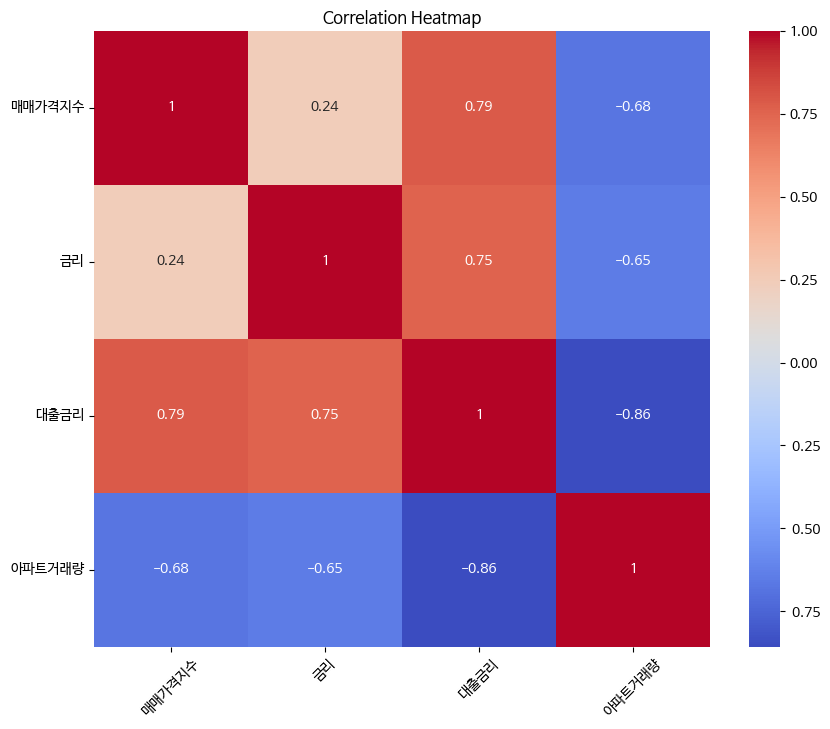

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', square=True)

plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

In [ ]:
correlation1 = df1.corr()
correlation1

,심리지수,매매가격지수,금리,대출금리,아파트거래량
심리지수,1.000000,-0.333052,-0.055139,-0.210733,0.075203
매매가격지수,-0.333052,1.000000,0.241281,0.788135,-0.682390
금리,-0.055139,0.241281,1.000000,0.754984,-0.647646
대출금리,-0.210733,0.788135,0.754984,1.000000,-0.857420
아파트거래량,0.075203,-0.682390,-0.647646,-0.857420,1.000000


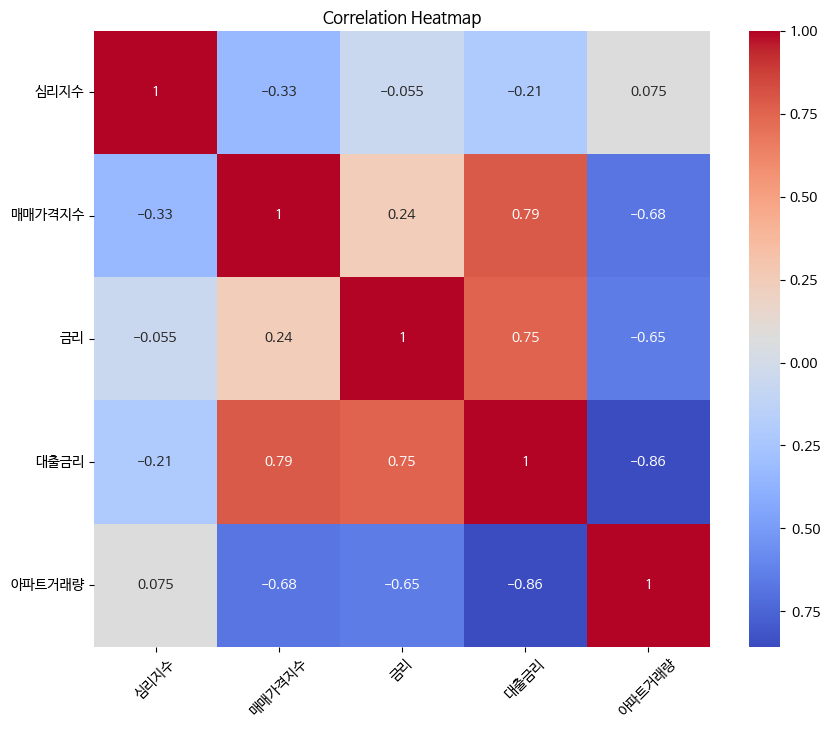

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation1, annot=True, cmap='coolwarm', square=True)

plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

# LSTM (심리지수 제외)

In [ ]:
# df.set_index('시점', inplace=True)
df.head()

,매매가격지수,금리,국내총생산,대출금리,아파트거래량
시점,,,,,
2019-01-01,75.859101,455551.1,1.75,3.12,91868
2019-02-01,75.772352,455551.1,1.75,3.08,78825
2019-03-01,75.626463,455551.1,1.75,3.04,90720
2019-04-01,75.443869,480832.1,1.75,2.98,89977
2019-05-01,75.339340,480832.1,1.75,2.93,82498


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['매매가격지수'].values.reshape(-1,1))

In [ ]:
prediction_months = 3
sequence_length = 3

X, y = [], []

for i in range(len(scaled_data) - sequence_length - prediction_months):
    X.append(scaled_data[i:i + sequence_length])
    y.append(scaled_data[i + sequence_length:i + sequence_length + prediction_months])

X, y = np.array(X), np.array(y)

In [ ]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=prediction_months))

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 3, 128)            66560     
                                                                 
 dropout_38 (Dropout)        (None, 3, 128)            0         
                                                                 
 lstm_54 (LSTM)              (None, 3, 64)             49408     
                                                                 
 dropout_39 (Dropout)        (None, 3, 64)             0         
                                                                 
 lstm_55 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_40 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 3)               

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=512, batch_size=64)

Epoch 1/512
1/1 [==============================] - 5s 5s/step - loss: 0.3929
Epoch 2/512
1/1 [==============================] - 0s 18ms/step - loss: 0.3870
Epoch 3/512
1/1 [==============================] - 0s 21ms/step - loss: 0.3785
Epoch 4/512
1/1 [==============================] - 0s 20ms/step - loss: 0.3729
Epoch 5/512
1/1 [==============================] - 0s 22ms/step - loss: 0.3631
Epoch 6/512
1/1 [==============================] - 0s 23ms/step - loss: 0.3557
Epoch 7/512
1/1 [==============================] - 0s 21ms/step - loss: 0.3464
Epoch 8/512
1/1 [==============================] - 0s 26ms/step - loss: 0.3353
Epoch 9/512
1/1 [==============================] - 0s 22ms/step - loss: 0.3238
Epoch 10/512
1/1 [==============================] - 0s 24ms/step - loss: 0.3104
Epoch 11/512
1/1 [==============================] - 0s 23ms/step - loss: 0.2960
Epoch 12/512
1/1 [==============================] - 0s 23ms/step - loss: 0.2790
Epoch 13/512
1/1 [==============================] -

In [ ]:
last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
predicted_prices = []

for _ in range(prediction_months):
    prediction = model.predict(last_sequence)
    predicted_prices.append(prediction[0, 0])

    last_sequence = np.roll(last_sequence, shift=-1, axis=1)
    last_sequence[0, -1, 0] = prediction[0, 0]

predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

current_date = df.index[-1]
next_months = [current_date + pd.DateOffset(months=i) for i in range(1, prediction_months + 1)]

predictions_df = pd.DataFrame(data={'Date': next_months, 'Predicted_Price': predicted_prices.flatten()})
print(predictions_df)

1/1 [==============================] - 0s 19ms/step
        Date  Predicted_Price
0 2023-04-01        97.836754
1 2023-05-01        97.388824
2 2023-06-01        97.686607


# LSTM (심리지수 포함)

In [ ]:
df1.head(3)

,매매가격지수,심리지수,국내총생산,금리,대출금리,아파트거래량
시점,,,,,,
2019-01-01,75.859101,122,455551.1,1.75,3.12,91868
2019-02-01,75.772352,114,455551.1,1.75,3.08,78825
2019-03-01,75.626463,171,455551.1,1.75,3.04,90720


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df1['매매가격지수'].values.reshape(-1,1))

In [ ]:
prediction_months = 3
sequence_length = 3
X, y = [], []

for i in range(len(scaled_data) - sequence_length - prediction_months):
    X.append(scaled_data[i:i + sequence_length])
    y.append(scaled_data[i + sequence_length:i + sequence_length + prediction_months])

X, y = np.array(X), np.array(y)

In [ ]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=prediction_months))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=512, batch_size=64)

Epoch 1/512
1/1 [==============================] - 6s 6s/step - loss: 0.3978
Epoch 2/512
1/1 [==============================] - 0s 24ms/step - loss: 0.3889
Epoch 3/512
1/1 [==============================] - 0s 16ms/step - loss: 0.3797
Epoch 4/512
1/1 [==============================] - 0s 16ms/step - loss: 0.3725
Epoch 5/512
1/1 [==============================] - 0s 15ms/step - loss: 0.3640
Epoch 6/512
1/1 [==============================] - 0s 14ms/step - loss: 0.3561
Epoch 7/512
1/1 [==============================] - 0s 15ms/step - loss: 0.3441
Epoch 8/512
1/1 [==============================] - 0s 16ms/step - loss: 0.3348
Epoch 9/512
1/1 [==============================] - 0s 15ms/step - loss: 0.3241
Epoch 10/512
1/1 [==============================] - 0s 15ms/step - loss: 0.3094
Epoch 11/512
1/1 [==============================] - 0s 15ms/step - loss: 0.2993
Epoch 12/512
1/1 [==============================] - 0s 15ms/step - loss: 0.2813
Epoch 13/512
1/1 [==============================] -

In [ ]:
last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
predicted_prices = []

for _ in range(prediction_months):
    prediction = model.predict(last_sequence)
    predicted_prices.append(prediction[0, 0])

    last_sequence = np.roll(last_sequence, shift=-1, axis=1)
    last_sequence[0, -1, 0] = prediction[0, 0]

predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

current_date = df.index[-1]
next_months = [current_date + pd.DateOffset(months=i) for i in range(1, prediction_months + 1)]

predictions_df = pd.DataFrame(data={'Date': next_months, 'Predicted_Price': predicted_prices.flatten()})
print(predictions_df)

1/1 [==============================] - 0s 16ms/step
        Date  Predicted_Price
0 2023-04-01        97.117424
1 2023-05-01        96.674805
2 2023-06-01        96.870819


# Multihead-attention (심리지수 제외)

In [ ]:
df.head()

,시점,매매가격지수,금리,국내총생산,대출금리,아파트거래량
0,2019-01-01,75.859101,1.75,"455,551.1",3.12,91868
1,2019-02-01,75.772352,1.75,"455,551.1",3.08,78825
2,2019-03-01,75.626463,1.75,"455,551.1",3.04,90720
3,2019-04-01,75.443869,1.75,"480,832.1",2.98,89977
4,2019-05-01,75.339340,1.75,"480,832.1",2.93,82498


In [ ]:
df['매매가격지수'] = pd.to_numeric(df['매매가격지수'], errors='coerce')
df['국내총생산'] = df['국내총생산'].str.replace(',', '').astype(float)
df['대출금리'] = pd.to_numeric(df['대출금리'], errors='coerce')
df['아파트거래량'] = pd.to_numeric(df['아파트거래량'], errors='coerce')
df.dtypes

시점        datetime64[ns]
매매가격지수           float64
금리               float64
국내총생산            float64
대출금리             float64
아파트거래량             int64
dtype: object

In [ ]:
df.set_index('시점', inplace=True)
df.head()

,매매가격지수,금리,국내총생산,대출금리,아파트거래량
시점,,,,,
2019-01-01,75.859101,1.75,455551.1,3.12,91868
2019-02-01,75.772352,1.75,455551.1,3.08,78825
2019-03-01,75.626463,1.75,455551.1,3.04,90720
2019-04-01,75.443869,1.75,480832.1,2.98,89977
2019-05-01,75.339340,1.75,480832.1,2.93,82498


In [ ]:
train_df = df.query("시점 < '2021-12-01'")
valid_df = df.query("시점 >= '2021-06-01' and 시점 < '2022-05-01'")
test_df = df.query("시점 >= '2022-04-01' and 시점 <= '2023-03-01'")

In [ ]:
train_df.tail()

,매매가격지수,금리,국내총생산,대출금리,아파트거래량
시점,,,,,
2021-07-01,92.603555,0.50,"531,525.5",2.81,102785
2021-08-01,94.440802,0.50,"531,525.5",2.88,98278
2021-09-01,96.299362,0.75,"531,525.5",3.01,89499
2021-10-01,97.562890,0.75,"546,939.7",3.26,85762
2021-11-01,99.065100,0.75,"546,939.7",3.51,78341


In [ ]:
valid_df.head()

,매매가격지수,금리,국내총생산,대출금리,아파트거래량
시점,,,,,
2021-06-01,91.217765,0.50,"517,054.3",2.74,105502
2021-07-01,92.603555,0.50,"531,525.5",2.81,102785
2021-08-01,94.440802,0.50,"531,525.5",2.88,98278
2021-09-01,96.299362,0.75,"531,525.5",3.01,89499
2021-10-01,97.562890,0.75,"546,939.7",3.26,85762


In [ ]:
test_df.head()

,매매가격지수,금리,국내총생산,대출금리,아파트거래량
시점,,,,,
2022-04-01,100.460384,1.25,"544,239.8",3.90,74575
2022-05-01,100.711938,1.50,"544,239.8",3.90,63769
2022-06-01,100.752493,1.75,"544,239.8",4.04,60119
2022-07-01,100.677875,1.75,"548,892.5",4.16,42595
2022-08-01,100.449869,2.25,"548,892.5",4.35,51007


In [ ]:
# 데이터 scaling

from sklearn.preprocessing import MinMaxScaler

def preprocessing(df):
    timesteps = 3  # 시계열 예측 input 길이
    X = []          # 독립변수
    y = []          # 종속변수

    for i in range(timesteps, df.shape[0]):
        X.append(df[i - timesteps:i])
        y.append(df[i][0])  # Index 1 corresponds to "매매가격지수"

    X = np.array(X)
    y = np.array(y)

    return X, y

def scaling(df):
  scale = MinMaxScaler(feature_range=(0, 1))
  features = ['매매가격지수', '국내총생산', '대출금리', '아파트거래량']

  scaledDf = scale.fit_transform(df[features]) # 스케일링된 값

  addCol = np.array(df['금리'])
  addCol = addCol.reshape(-1, 1)

  result = np.hstack((scaledDf, addCol))

  return result

def reverse_scaling(org_x, x):
  org_x = np.asarray(org_x)
  x     = np.asarray(x)

  return (x * (org_x.max() - org_x.min() + 1e-7)) + org_x.min()

In [ ]:
X_train, y_train = preprocessing(scaling(train_df))
X_val, y_val = preprocessing(scaling(valid_df))
X_test, y_test = preprocessing(scaling(test_df))

In [ ]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [ ]:
print(f'train X 길이 : {len(X_train)}, train y 길이 : {len(y_train)}')
print(f'val X 길이 : {len(X_val)}, val y 길이 : {len(y_val)}')
print(f'test X 길이 : {len(X_test)}, test y 길이 : {len(y_test)}')

train X 길이 : 32, train y 길이 : 32
val X 길이 : 8, val y 길이 : 8
test X 길이 : 9, test y 길이 : 9


In [ ]:
# Attention 설계

import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras import backend as K

class Attention(Layer):
    # Insert **kwargs to __init__() function.
    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences

        super(Attention,self).__init__()

    def get_config(self):
        config = super().get_config()
        config.update({
            "return_sequences": self.return_sequences,
        })
        return config

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))
        super(Attention,self).build(input_shape)

    def call(self, x):                         # Attention 가중치 계산
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
          return output
        return K.sum(output, axis=1)

# 8개의 multihead-attention으로 구성
class MultiAttention(Layer):
  def __init__(self, n_heads):
    super(MultiAttention, self).__init__()
    self.n_heads = n_heads
    self.attn_heads = list()
    self.units = 8

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(Attention(return_sequences=True))

    self.linear = Dense(self.units,
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min', baseline=0.0001)
callbacks_list = [earlystop]
hl = [64, 32]
lr = 1e-3
batch_size = 64
epochs = 512

In [ ]:
model = Sequential()

model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                activation = 'relu'))

for i in range(len(hl)):
    model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))

model.add(Dropout(0.2))
model.add(LSTM(hl[-1],activation = 'relu'))
model.add(Dense(1))
model.add(MultiAttention(n_heads=16))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

In [ ]:
model.fit(X_train, y_train,
          epochs = epochs,
          batch_size = batch_size,
          validation_data = (X_val, y_val),
          verbose = 0,
          shuffle = False,
          callbacks=callbacks_list)

Epoch 42: early stopping


In [ ]:
y_hat = model.predict(X_test)

1/1 [==============================] - 1s 731ms/step


In [ ]:
y_hat = y_hat[-3:]

In [ ]:
predict = df.tail(3)
pre = pd.concat([predict], axis=0)
pre

,매매가격지수,금리,국내총생산,대출금리,아파트거래량
시점,,,,,
2023-01-01,94.724287,3.25,523816.2,4.58,39124
2023-02-01,93.626154,3.50,523816.2,4.56,63909
2023-03-01,92.481888,3.50,523816.2,4.40,59750


In [ ]:
Y_org = np.array(pre['매매가격지수'])
Y_test = reverse_scaling(Y_org, y_test[-3:])    # 실제값
Y_test

array([93.08986685, 92.79213147, 92.48188788])

In [ ]:
Y_hat = reverse_scaling(Y_org, y_hat)
Y_hat

array([[93.7839  ],
       [93.727425],
       [93.6928  ]], dtype=float32)

In [ ]:
Y_hat = np.concatenate(Y_hat).tolist()
Y_hat = np.array(Y_hat)    # 모델 예측값
Y_hat

array([93.7838974 , 93.72742462, 93.69280243])

In [ ]:
from math import sqrt

mse = mean_squared_error(y_test[-3:], y_hat)
rmse = sqrt(mse)

print(f'MSE = {mse}')
print(f'RMSE = {rmse}')

MSE = 0.18712331206128652
RMSE = 0.4325775214470656


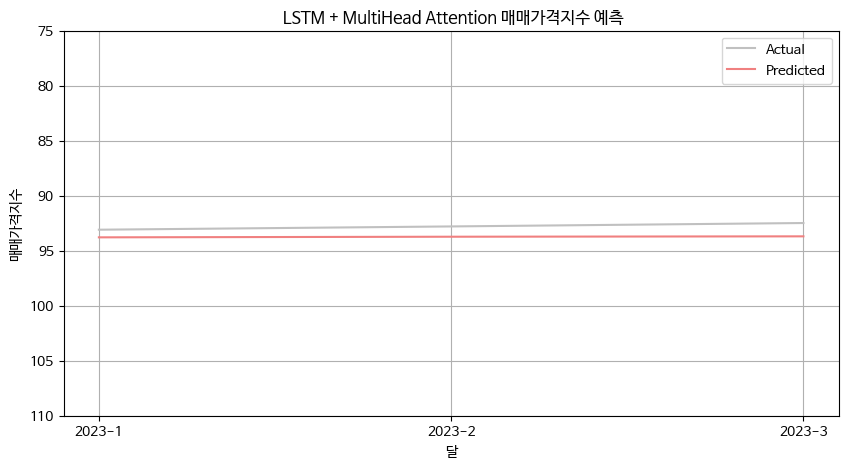

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 10
minPrice = 110
maxPrice = 75

plt.figure(figsize = (10, 5))
plt.plot(Y_test, c = 'silver') # 위에서 실제 Open price 역스케일한 값
plt.plot(Y_hat, c = 'lightcoral') # 위에서 예측 Open price 역스케일한 값
plt.xlabel('달', fontsize=10)
plt.ylabel('매매가격지수', fontsize=10)
plt.ylim(minPrice, maxPrice)
ticklabel=['2023-1', '2023-2', '2023-3']
X=[0, 1, 2]
plt.xticks(X,ticklabel)

plt.title(' LSTM + MultiHead Attention 매매가격지수 예측')
plt.legend(['Actual','Predicted'],loc = 'upper right')
plt.grid()
plt.show()

# Multihead-attention(심리지수 포함)

In [ ]:
df1.head()

,시점,심리지수,매매가격지수,국내총생산,금리,대출금리,아파트거래량
0,2019-01-01,122,75.859101,"455,551.1",1.75,3.12,91868
1,2019-02-01,114,75.772352,"455,551.1",1.75,3.08,78825
2,2019-03-01,171,75.626463,"455,551.1",1.75,3.04,90720
3,2019-04-01,174,75.443869,"480,832.1",1.75,2.98,89977
4,2019-05-01,183,75.339340,"480,832.1",1.75,2.93,82498


In [ ]:
df1 = df1[['시점', '매매가격지수', '심리지수', '국내총생산', '금리', '대출금리', '아파트거래량']]
df1.head()

,시점,매매가격지수,심리지수,국내총생산,금리,대출금리,아파트거래량
0,2019-01-01,75.859101,122,"455,551.1",1.75,3.12,91868
1,2019-02-01,75.772352,114,"455,551.1",1.75,3.08,78825
2,2019-03-01,75.626463,171,"455,551.1",1.75,3.04,90720
3,2019-04-01,75.443869,174,"480,832.1",1.75,2.98,89977
4,2019-05-01,75.339340,183,"480,832.1",1.75,2.93,82498


In [ ]:
df1['매매가격지수'] = pd.to_numeric(df1['매매가격지수'], errors='coerce')
df1['국내총생산'] = df1['국내총생산'].str.replace(',', '').astype(float)
df1['대출금리'] = pd.to_numeric(df1['대출금리'], errors='coerce')
df1['아파트거래량'] = pd.to_numeric(df1['아파트거래량'], errors='coerce')
df1.dtypes

시점        datetime64[ns]
매매가격지수           float64
심리지수               int64
국내총생산            float64
금리               float64
대출금리             float64
아파트거래량             int64
dtype: object

In [ ]:
df1.set_index('시점', inplace=True)
df1.head()

,매매가격지수,심리지수,국내총생산,금리,대출금리,아파트거래량
시점,,,,,,
2019-01-01,75.859101,122,455551.1,1.75,3.12,91868
2019-02-01,75.772352,114,455551.1,1.75,3.08,78825
2019-03-01,75.626463,171,455551.1,1.75,3.04,90720
2019-04-01,75.443869,174,480832.1,1.75,2.98,89977
2019-05-01,75.339340,183,480832.1,1.75,2.93,82498


In [ ]:
train_df1 = df1.query("시점 < '2021-12-01'")
valid_df1 = df1.query("시점 >= '2021-06-01' and 시점 < '2022-05-01'")
test_df1 = df1.query("시점 >= '2022-04-01' and 시점 <= '2023-03-01'")

In [ ]:
train_df1.tail(2)

,매매가격지수,심리지수,국내총생산,금리,대출금리,아파트거래량
시점,,,,,,
2021-10-01,97.56289,2,546939.7,0.75,3.26,85762
2021-11-01,99.06510,33,546939.7,0.75,3.51,78341


In [ ]:
# 데이터 scaling

from sklearn.preprocessing import MinMaxScaler

def preprocessing(df):
    timesteps = 3  # 시계열 예측 input 길이
    X = []          # 독립변수
    y = []          # 종속변수

    for i in range(timesteps, df.shape[0]):
        X.append(df[i - timesteps:i])
        y.append(df[i][0])  # Index 1 corresponds to "매매가격지수"

    X = np.array(X)
    y = np.array(y)

    return X, y

def scaling(df):
  scale = MinMaxScaler(feature_range=(0, 1))
  features = ['매매가격지수', '심리지수', '국내총생산', '대출금리', '아파트거래량']

  scaledDf = scale.fit_transform(df[features]) # 스케일링된 값

  addCol = np.array(df['금리'])
  addCol = addCol.reshape(-1, 1)

  result = np.hstack((scaledDf, addCol))

  return result

def reverse_scaling(org_x, x):
  org_x = np.asarray(org_x)
  x     = np.asarray(x)

  return (x * (org_x.max() - org_x.min() + 1e-7)) + org_x.min()

In [ ]:
X_train1, y_train1 = preprocessing(scaling(train_df1))
X_val1, y_val1 = preprocessing(scaling(valid_df1))
X_test1, y_test1 = preprocessing(scaling(test_df1))

In [ ]:
print(f'train X1 길이 : {len(X_train1)}, train y1 길이 : {len(y_train1)}')
print(f'val X1 길이 : {len(X_val1)}, val y1 길이 : {len(y_val1)}')
print(f'test X1 길이 : {len(X_test1)}, test y1 길이 : {len(y_test1)}')

train X1 길이 : 32, train y1 길이 : 32
val X1 길이 : 8, val y1 길이 : 8
test X1 길이 : 9, test y1 길이 : 9


In [ ]:
import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras import backend as K

class Attention(Layer):
    # Insert **kwargs to __init__() function.
    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences

        super(Attention,self).__init__()

    def get_config(self):
        config = super().get_config()
        config.update({
            "return_sequences": self.return_sequences,
        })
        return config

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))
        super(Attention,self).build(input_shape)

    def call(self, x):                         # Attention 가중치 계산
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
          return output
        return K.sum(output, axis=1)

# 8개의 multihead-attention으로 구성
class MultiAttention(Layer):
  def __init__(self, n_heads):
    super(MultiAttention, self).__init__()
    self.n_heads = n_heads
    self.attn_heads = list()
    self.units = 8

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(Attention(return_sequences=True))

    self.linear = Dense(self.units,
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min', baseline=0.0001)
callbacks_list = [earlystop]
hl = [64, 32]
lr = 1e-3
batch_size = 64
epochs = 512

In [ ]:
model1 = Sequential()

model1.add(LSTM(X_train1.shape[2],input_shape = (X_train1.shape[1],X_train1.shape[2]),return_sequences = True,
                activation = 'relu'))

for i in range(len(hl)):
    model1.add(LSTM(hl[i],activation = 'relu',return_sequences = True))

model1.add(Dropout(0.2))
model1.add(LSTM(hl[-1],activation = 'relu'))
model1.add(Dense(1))
model1.add(MultiAttention(n_heads=16))
model1.add(Dense(1))
model1.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

In [ ]:
model1.fit(X_train1, y_train1,
          epochs = epochs,
          batch_size = batch_size,
          validation_data = (X_val1, y_val1),
          verbose = 0,
          shuffle = False,
          callbacks=callbacks_list)

Epoch 10: early stopping


In [ ]:
y_hat1 = model1.predict(X_test1)

y_hat1 = y_hat1[-3:]

1/1 [==============================] - 1s 609ms/step


In [ ]:
predict1 = df1.tail(3)
pre1 = pd.concat([predict1], axis=0)
pre1

,매매가격지수,심리지수,국내총생산,금리,대출금리,아파트거래량
시점,,,,,,
2023-01-01,94.724287,6,523816.2,3.25,4.58,39124
2023-02-01,93.626154,-25,523816.2,3.50,4.56,63909
2023-03-01,92.481888,105,523816.2,3.50,4.40,59750


In [ ]:
Y_org1 = np.array(pre1['매매가격지수'])
Y_test1 = reverse_scaling(Y_org1, y_test1[-3:])    # 실제값
Y_test1

array([93.08986685, 92.79213147, 92.48188788])

In [ ]:
Y_hat1 = reverse_scaling(Y_org1, y_hat1)
Y_hat1

array([[93.18761],
       [93.18486],
       [93.18293]], dtype=float32)

In [ ]:
Y_hat1 = np.concatenate(Y_hat1).tolist()
Y_hat1 = np.array(Y_hat1)    # 모델 예측값
Y_hat1

array([93.18760681, 93.18486023, 93.18292999])

In [ ]:
from math import sqrt

mse1 = mean_squared_error(y_test1[-3:], y_hat1)
rmse1 = sqrt(mse1)

print(f'MSE = {mse1}')
print(f'RMSE = {rmse1}')

MSE = 0.043437426534727624
RMSE = 0.2084164737604195


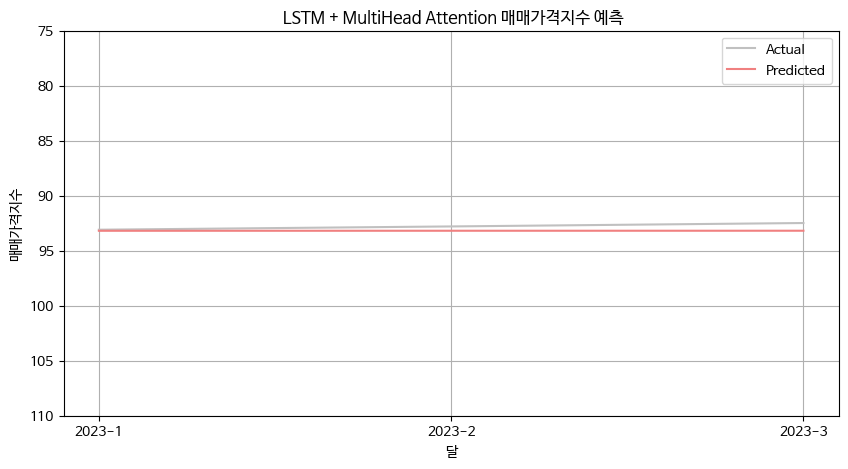

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 10
minPrice = 110
maxPrice = 75

plt.figure(figsize = (10, 5))
plt.plot(Y_test1, c = 'silver') # 위에서 실제 Open price 역스케일한 값
plt.plot(Y_hat1, c = 'lightcoral') # 위에서 예측 Open price 역스케일한 값
plt.xlabel('달', fontsize=10)
plt.ylabel('매매가격지수', fontsize=10)
plt.ylim(minPrice, maxPrice)
ticklabel=['2023-1', '2023-2', '2023-3']
X=[0, 1, 2]
plt.xticks(X,ticklabel)

plt.title(' LSTM + MultiHead Attention 매매가격지수 예측')
plt.legend(['Actual','Predicted'],loc = 'upper right')
plt.grid()
plt.show()